<a href="https://colab.research.google.com/github/MuhammadBilall/FIX-Parser/blob/main/FIX_Parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
dataFolder = '/content/drive/MyDrive/FIX-Messages/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import os
import glob
dataFiles = []
txt_files = glob.glob(dataFolder + "*.txt")
#print(txt_files)
for filename in txt_files:  
    print("Reading File: ", filename)
    data = pd.read_fwf(filename, header=None)
    dataFiles.append(data)

#print(dataFiles[0])

['/content/drive/MyDrive/FIX-Messages/2020-08-12 Messages.txt', '/content/drive/MyDrive/FIX-Messages/2020-08-11 Messages.txt']
Reading File:  /content/drive/MyDrive/FIX-Messages/2020-08-12 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages/2020-08-11 Messages.txt


In [3]:
def GetTagValue(msg, tag):
    splits = msg.split("\001")
    for s in splits:
        temp = s.split("=")
        if temp[0] == tag:
            return temp[1]
    return -1    

In [6]:
def ToDataFrame(dataFiles, tags):
    dataChunks = []

    for data in dataFiles:
        rows = []

        for i in range(len(data)):
            row = []

            for tag in tags:
                msg = data.at[i,0]
                value = GetTagValue(msg, tag)
                #print("msg num: ", i, "tag: ", tag, "value: ", value)
                row.append(value)

            rows.append(row)

        dataChunks.append(pd.DataFrame(rows, columns = tags))
        
    dataFrame = pd.concat(dataChunks, ignore_index=True)
    return dataFrame

In [8]:
tags = ['9', '35', '52', '34', '49', '56', '11', '55', '167', '54', '60', '37', '38', '40', '17', '41', '44']
dataFrame = ToDataFrame(dataFiles, tags)
print(dataFrame)

         9 35  ...              41         44
0      196  D  ...              -1  21.540000
1      253  8  ...              -1  21.540000
2      185  F  ...   Q8P-AXK-Q8P-1         -1
3      233  8  ...   Q8P-AXK-Q8P-1         -1
4      197  D  ...              -1  21.530000
...    ... ..  ...             ...        ...
64233  241  8  ...  QCF-3MG7-QCF-1         -1
64234  201  D  ...              -1  15.200000
64235  259  8  ...              -1  15.200000
64236  191  F  ...  TU7-4QZQ-TU7-1         -1
64237  240  8  ...  TU7-4QZQ-TU7-1         -1

[64238 rows x 17 columns]


In [9]:
dataFrame.to_csv(os.path.join(dataFolder, 'CleanData.csv'), index=False)

In [112]:
#!pip install maya
from datetime import datetime
import maya
times = dataFrame['52']
dt = []
hours = []
weekdays = []
for i in range(0,len(times)):
    dt.append(maya.parse(times[i]).datetime())
    hours.append(dt[i].hour)
    weekdays.append(dt[i].weekday())

In [118]:
#hours[0].strftime("%I:%M %p")

In [115]:
from collections import Counter
hours_count = Counter(hours)
weekday_count = Counter(weekdays)

Counter({1: 38560, 2: 25678})

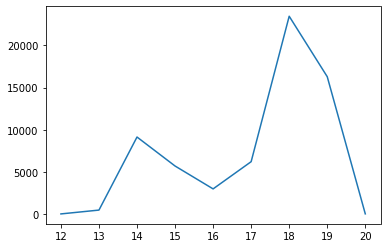

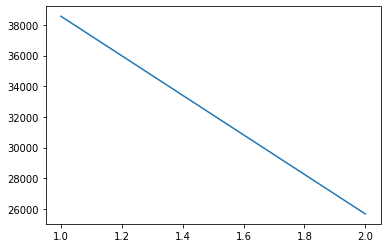

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=hours_count)
plt.show()
sns.lineplot(data=weekday_count)
plt.show()